In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")

In [3]:
Tr.fit(modelpath="tmp_Qnet.joblib")

In [4]:
pd.DataFrame(samples)

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,4,2,5,4,2,3,2,3,3,2,...,2,4,4,3,2,3,2,2,4,2
1,3,2,3,3,1,3,2,2,2,1,...,3,4,4,3,3,3,4,3,4,5
2,2,2,2,4,1,3,3,2,2,4,...,4,2,2,4,4,2,3,2,2,5
3,2,2,5,1,3,2,1,2,2,1,...,1,2,3,3,3,2,1,1,2,2
4,4,1,1,1,2,2,1,1,1,2,...,2,2,2,2,1,1,2,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,4,2,3,4,1,1,1,1,3,2,...,2,2,2,2,2,2,2,2,2,3
300,5,2,2,4,4,3,2,5,4,4,...,5,5,5,5,4,5,5,4,4,5
301,5,1,2,1,1,3,5,5,3,4,...,4,3,3,2,3,1,3,2,5,5
302,2,1,3,3,1,2,2,2,1,1,...,1,1,1,1,1,2,2,2,2,2


In [4]:
samples

array([['4', '2', '5', ..., '2', '4', '2'],
       ['3', '2', '3', ..., '3', '4', '5'],
       ['2', '2', '2', ..., '2', '2', '5'],
       ...,
       ['5', '1', '2', ..., '2', '5', '5'],
       ['2', '1', '3', ..., '2', '2', '2'],
       ['5', '2', '1', ..., '2', '1', '4']], dtype='<U21')

We order questions based on increasing entropy: questions with the least entropy have the most potential for dissonant/surprising responses. (This could also be done dynamically: after each response, recompute the distributions and choose the remaining one with minimal entropy.)

In [4]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_m2 = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))

        new_samp_m3[i] = random.choices(
            sample_values[i], weights=sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "m2_diss": mean_diss_m2,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [5]:
Ds = Tr.cognet_obj.qnet.predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

entropy_order = pd.Series(entrpy).sort_values().index

## Linear dissonance

### Entropy ordering

In [10]:
mean_dfs = [
    _compare_dissonance(samples, Tr.cognet_obj.qnet, order=entropy_order, plot=False)
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

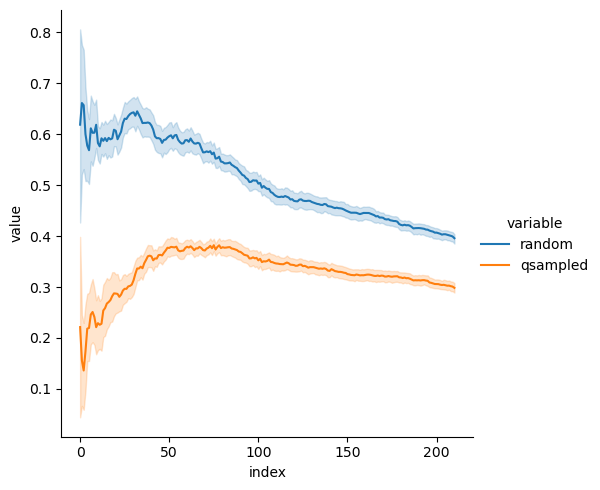

In [16]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

### Random ordering

In [20]:
random_order = list(range(len(samples[0])))
random.shuffle(random_order)

mean_dfs = [
    _compare_dissonance(samples, Tr.cognet_obj.qnet, order=random_order, plot=False)
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

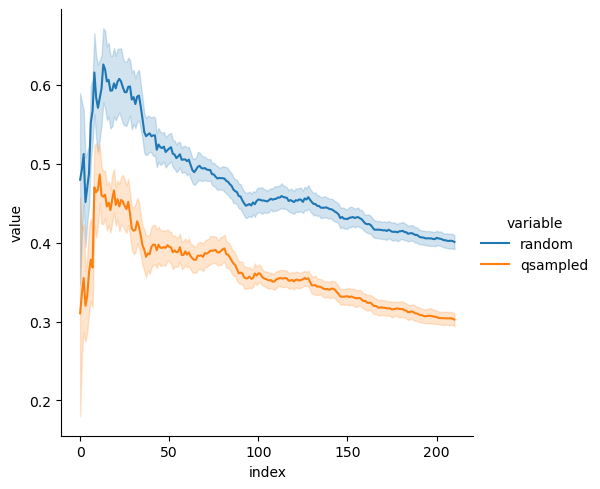

In [21]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Log. dissonance

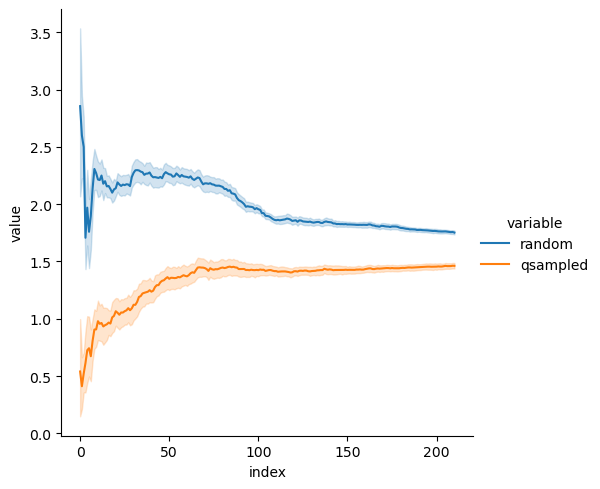

In [7]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Adversarial responses

In [6]:
Tr_pos = truthnet()
# feat_pos, samp_pos = pos_samps.columns, pos_samps.to_numpy(dtype='<U21', na_value='')
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

In [19]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

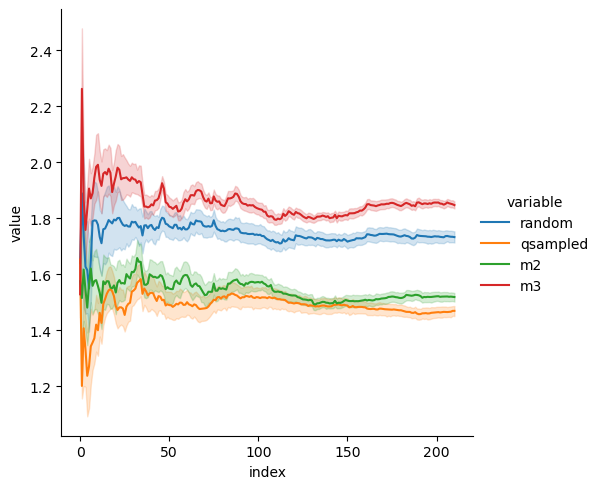

In [20]:
sns.relplot(
    data=pd.melt(pd.concat(mean_dfs).reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Classification


Get dissonance values for number of runs, store in dataframe

In [8]:
dfs = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            order=entropy_order,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(5))
    ]
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
dfs

,random_diss,qsampled_diss,m2_diss,m3_diss,random_resp,qsampled_resp,m2_resp,m3_resp,run
0,0.885496,0.000000,0.000000,0.984733,4,2,2,4,0
1,0.919402,0.000000,0.482490,0.974857,2,2,1,4,0
2,0.612935,0.000000,0.631499,0.959743,3,2,4,1,0
3,0.488327,0.246324,0.653010,0.741245,1,3,3,4,0
4,0.574161,0.197059,0.522408,0.791061,2,3,1,3,0
...,...,...,...,...,...,...,...,...,...
206,0.399106,0.324308,0.334914,0.449808,2,2,2,4,4
207,0.398419,0.323263,0.335601,0.449622,1,1,4,5,4
208,0.397084,0.323179,0.333686,0.447534,5,1,5,3,4
209,0.396747,0.323333,0.333045,0.448334,3,3,3,3,4


In [16]:
["qsampled_diss"] + ["run"]

['qsampled_diss', 'run']

In [17]:
def _get_quest_diss(diss_df, type, questions):
    filt_df = (
        diss_df[type + ["run"]]
        .reset_index(names="question_index")
        .query("question_index.isin(@questions)")
        .pivot_table(index="run", columns="question_index")
    )

    filt_df.columns = filt_df.columns.to_flat_index()

    return filt_df.reset_index(drop=True)

In [24]:
_get_quest_diss(dfs, ["m2_diss"], range(0, 211, 5)).columns[0][0].replace("m2_", "")

'diss'

In [31]:
pd.concat(
    [
        _get_quest_diss(dfs, ["qsampled_diss"], range(0, 211, 5))
        .rename(columns=lambda x: (x[0].replace("qsampled_", ""), x[1]))
        .assign(adv=0),
        _get_quest_diss(dfs, ["m2_diss"], range(0, 211, 5))
        .rename(columns=lambda x: (x[0].replace("m2_", ""), x[1]))
        .assign(adv=1),
    ],
    axis=0,
)

,"(diss, 0)","(diss, 5)","(diss, 10)","(diss, 15)","(diss, 20)","(diss, 25)","(diss, 30)","(diss, 35)","(diss, 40)","(diss, 45)",...,"(diss, 170)","(diss, 175)","(diss, 180)","(diss, 185)","(diss, 190)","(diss, 195)","(diss, 200)","(diss, 205)","(diss, 210)",adv
0,0.000000,0.164216,0.089573,0.179353,0.175177,0.218545,0.285203,0.306100,0.320178,0.310864,...,0.333231,0.331922,0.320436,0.319144,0.319226,0.310223,0.309090,0.311452,0.312354,0
1,0.984733,0.166667,0.090734,0.282500,0.304114,0.275648,0.338362,0.280685,0.305428,0.304440,...,0.328922,0.327603,0.326261,0.323432,0.317703,0.316034,0.319140,0.311753,0.311452,0
2,0.000000,0.333333,0.232036,0.346650,0.354049,0.408068,0.444237,0.436559,0.432101,0.416065,...,0.329121,0.324254,0.324204,0.330149,0.330370,0.337455,0.333440,0.328430,0.327740,0
3,0.000000,0.282691,0.391885,0.472781,0.407382,0.351566,0.386170,0.404103,0.389322,0.374545,...,0.308838,0.310980,0.311268,0.315797,0.313735,0.303201,0.301788,0.298234,0.297329,0
4,0.000000,0.321347,0.297449,0.313505,0.335549,0.386493,0.355545,0.413600,0.410568,0.413395,...,0.330664,0.328380,0.326769,0.320115,0.320185,0.322836,0.327901,0.327633,0.320399,0
0,0.000000,0.571258,0.560267,0.500751,0.478368,0.485457,0.483023,0.479871,0.528655,0.495209,...,0.327702,0.333410,0.317561,0.314031,0.309288,0.312274,0.309978,0.306633,0.298655,1
1,0.000000,0.164216,0.314886,0.302299,0.353246,0.367484,0.423671,0.392136,0.368983,0.394578,...,0.345133,0.339173,0.337229,0.338408,0.335967,0.336461,0.330429,0.329079,0.323100,1
2,0.000000,0.282691,0.283021,0.361212,0.451526,0.544101,0.617187,0.623448,0.637423,0.604263,...,0.400600,0.392421,0.377868,0.371235,0.366614,0.359525,0.348650,0.343896,0.336701,1
3,0.000000,0.319444,0.266278,0.235898,0.260578,0.324732,0.393760,0.374066,0.442127,0.452743,...,0.328176,0.325396,0.323890,0.319876,0.313771,0.314794,0.312845,0.306865,0.304632,1
4,0.885496,0.439821,0.309732,0.324604,0.397485,0.443192,0.546965,0.530945,0.560173,0.537313,...,0.350188,0.342609,0.342842,0.344329,0.342406,0.346662,0.345787,0.338045,0.329291,1


In [28]:
_get_quest_diss(dfs, ["qsampled_diss"], range(0, 211, 5)).rename(
    columns=lambda x: (x[0].replace("qsampled_", ""), x[1])
).assign(adv=0)

,"(diss, 0)","(diss, 5)","(diss, 10)","(diss, 15)","(diss, 20)","(diss, 25)","(diss, 30)","(diss, 35)","(diss, 40)","(diss, 45)",...,"(diss, 170)","(diss, 175)","(diss, 180)","(diss, 185)","(diss, 190)","(diss, 195)","(diss, 200)","(diss, 205)","(diss, 210)",adv
0,0.000000,0.164216,0.089573,0.179353,0.175177,0.218545,0.285203,0.306100,0.320178,0.310864,...,0.333231,0.331922,0.320436,0.319144,0.319226,0.310223,0.309090,0.311452,0.312354,0
1,0.984733,0.166667,0.090734,0.282500,0.304114,0.275648,0.338362,0.280685,0.305428,0.304440,...,0.328922,0.327603,0.326261,0.323432,0.317703,0.316034,0.319140,0.311753,0.311452,0
2,0.000000,0.333333,0.232036,0.346650,0.354049,0.408068,0.444237,0.436559,0.432101,0.416065,...,0.329121,0.324254,0.324204,0.330149,0.330370,0.337455,0.333440,0.328430,0.327740,0
3,0.000000,0.282691,0.391885,0.472781,0.407382,0.351566,0.386170,0.404103,0.389322,0.374545,...,0.308838,0.310980,0.311268,0.315797,0.313735,0.303201,0.301788,0.298234,0.297329,0
4,0.000000,0.321347,0.297449,0.313505,0.335549,0.386493,0.355545,0.413600,0.410568,0.413395,...,0.330664,0.328380,0.326769,0.320115,0.320185,0.322836,0.327901,0.327633,0.320399,0


In [119]:
pd.concat(
    [
        qfs[["qsampled_diss", "question_index", "run"]]
        .assign(adv=0)
        .set_axis(["diss", "quest", "run", "adv"], axis="columns"),
        qfs[["m2_diss", "question_index", "run"]]
        .assign(adv=1)
        .set_axis(["diss", "quest", "run", "adv"], axis="columns"),
    ],
    axis=0,
    ignore_index=True,
)

,diss,quest,run,adv
0,0.000000,0,0,0
1,0.000000,1,0,0
2,0.000000,2,0,0
3,0.000000,3,0,0
4,0.000000,4,0,0
...,...,...,...,...
2105,0.343345,206,4,1
2106,0.344989,207,4,1
2107,0.342744,208,4,1
2108,0.341480,209,4,1


In [99]:
dfs[["m2_diss", "run"]].assign(adv=1)

,m2_diss,run,adv
0,0.000000,0,1
1,0.000000,0,1
2,0.000000,0,1
3,0.246324,0,1
4,0.387478,0,1
...,...,...,...
206,0.343345,4,1
207,0.344989,4,1
208,0.342744,4,1
209,0.341480,4,1


In [103]:
qfs = dfs.reset_index(names="question_index")

In [108]:
qfs[["m2_diss", "question_index"]].assign(adv=1).set_axis(
    ["diss", "quest", "adv"], axis="columns"
)

,diss,quest,adv
0,0.000000,0,1
1,0.000000,1,1
2,0.000000,2,1
3,0.246324,3,1
4,0.387478,4,1
...,...,...,...
1050,0.343345,206,1
1051,0.344989,207,1
1052,0.342744,208,1
1053,0.341480,209,1


## Def. of dissonance

Letting $\text{ans}$ be the set of answers and a response $x \in \text{ans}$, the (linear) dissonance of $x$ is defined as $$\operatorname{Dissonance}(x)= 1 - \dfrac{\operatorname{Pr}(x)}{\operatorname{max}_{a \in \text{ans}}\operatorname{Pr}(a)}$$ 

Thus the dissonance is supported on $[0,1]$, is minimized at the highest probability response, and is maximal ($=1$) at probability $0$ responses. We also see that it scales linearly with probability of the response.

## Results

- distinguish between random/non-random responses
- reconstruction of responses
- include diagnostic phenotypes